In [1]:
import cv2
import numpy as np
from numpy.lib.stride_tricks import as_strided
import os
import matplotlib.pyplot as plt

In [2]:
def _pad_with(vector, pad_width, iaxis, kwargs):
    pad_value = kwargs.get('padder', 0)
    vector[:pad_width[0]] = pad_value
    vector[-pad_width[1]:] = pad_value

def _kick(res, sub_shape):
    L = []
    for i in res:
        if i.shape==sub_shape:
            L.append(i)
    return L

def _pad(X, k):
    XX_shape = tuple(np.subtract(X.shape, k.shape) + 1)
    if XX_shape!=X.shape:
        P = np.subtract(X.shape, XX_shape) // 2
        if len(np.unique(P))!=1:
            print('kernel is not square matrix')
        else:
            X_ = np.pad(X, P[0], _pad_with)
    else:
        X_ = np.copy(X)
    return X_


def _view_matrix(X, k):
    H, W = X.shape
    Hk, Wk = k.shape
    view_shape = tuple(np.subtract(X.shape, k.shape) + 1) + k.shape 
    res = []
    for h in range(H):
        for w in range(W):
            res.append(X[h:h+Hk, w:w+Wk]) 
    res_ = np.array(_kick(res, k.shape)).reshape(view_shape) 
    # res_ = _kick(res, k.shape)
    return res_  

def _conv2d(X, k):
    X = _pad(X, k)
    view = _view_matrix(X, k)
    result = np.einsum('klij,ij->kl', view, k)
    return result

def image_histogram_equalization(image, number_bins=225):
    image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
    cdf = image_histogram.cumsum() # cumulative distribution function
    cdf = 255 * cdf / cdf[-1] # normalize

    # use linear interpolation of cdf to find new pixel values
    image_equalized = np.interp(image.flatten(), bins[:-1], cdf)

    return image_equalized.reshape(image.shape)

def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g    


In [3]:
dP = './img'
sP = './result'

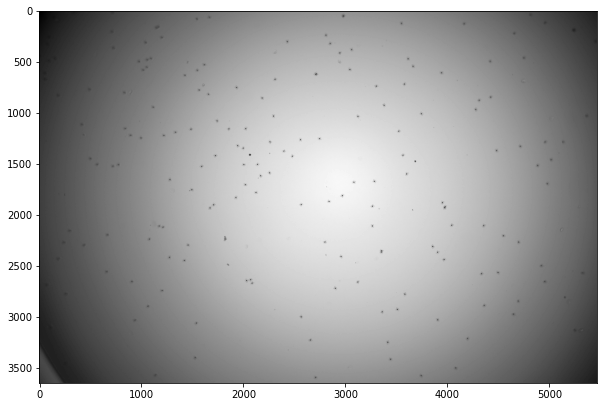

In [4]:
datalist = os.listdir(dP)
img_f = datalist[0]
image_org = cv2.imread(os.path.join(dP, img_f))
image = cv2.cvtColor(image_org, cv2.COLOR_BGR2GRAY)

fig = plt.figure(figsize=(10, 10))
plt.imshow(image, cmap='gray')

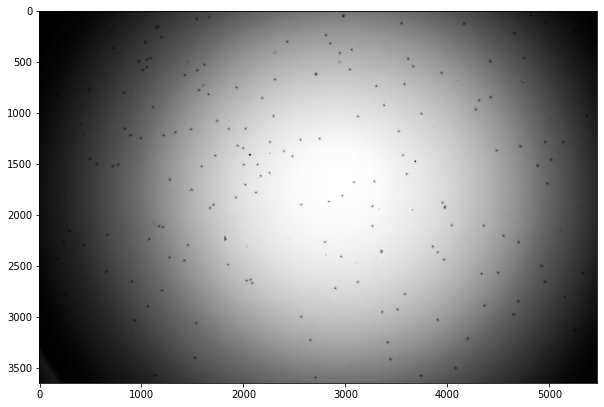

In [5]:
number_bins = 255
image_histogram, bins = np.histogram(image.flatten(), number_bins, density=True)
cdf = image_histogram.cumsum()
cdf = 255 * cdf / cdf[-1]
image_equalized = np.interp(image.flatten(), bins[:-1], cdf)
image_equalized = image_equalized.reshape(image.shape)

x_min, x_max = np.min(image_equalized), np.max(image_equalized)
img_hist = ((image_equalized - x_min) / (x_max - x_min)) * 255

# fig = plt.figure(figsize=(10, 10))
# plt.bar(np.arange(number_bins), image_histogram)
# fig = plt.figure(figsize=(10, 10))
# plt.bar(np.arange(number_bins), cdf)
fig = plt.figure(figsize=(10, 10))
plt.imshow(img_hist, cmap='gray')

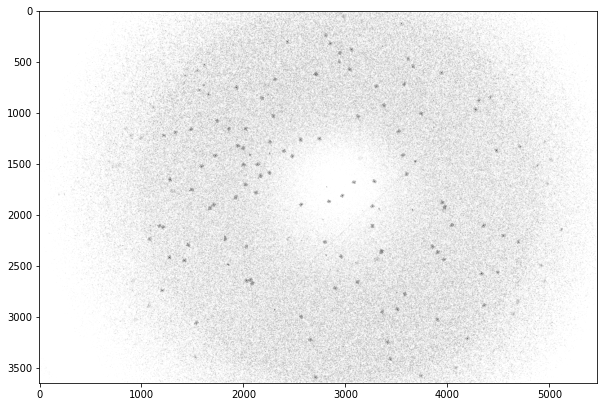

In [7]:
k = gaussian_kernel(11)
img_pad = _pad(img_hist, k)
view = _view_matrix(img_pad, k)
thold = np.einsum('klij,ij->kl', view, k) / np.sum(k) - 2

img_adpt_thold = np.greater_equal(img_hist, thold)

fig = plt.figure(figsize=(10, 10))
plt.imshow(img_adpt_thold, cmap='gray')